In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/ALMPC/examples/Project.toml`
Precompiling project...
  ✓ HTTP
  ✓ GR
  ✓ Plots
  3 dependencies successfully precompiled in 52 seconds (246 already precompiled)


In [2]:
using ALMPC
using StaticArrays
using SparseArrays
using LinearAlgebra
using OSQP
using Plots
using RobotDynamics
using Test

┌ Info: Precompiling ALMPC [4af787c9-3890-4ef7-a76d-b0ed3d7a1470]
└ @ Base loading.jl:1342
┌ Warning: Package ALMPC does not have StaticArrays in its dependencies:
│ - If you have ALMPC checked out for development and have
│   added StaticArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ALMPC
└ Loading StaticArrays into ALMPC from project dependency, future warnings for ALMPC are suppressed.
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


## System dynamics ##

A 2D point mass $m=2\; \text{kg}$ in subject to an input force $F_{ext}$ and viscous friction with coefficient $b = 0.3\;[N \cdot \frac{s}{m}]$.

\begin{equation}
\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}
\end{equation}

<span style='color:blue'> 


#### Continuous System Dynamics:

$$ \underbrace{\begin{bmatrix}
        \dot{x} \\
        \dot{y} \\
        \ddot{x} \\
        \ddot{y} 
\end{bmatrix}}_{\dot{x}} = \underbrace{\begin{bmatrix}
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & -\frac{b}{m} & 0 \\        
        0 & 0 & 0 & -\frac{b}{m} 
\end{bmatrix}}_{\text{A}} * \underbrace{\begin{bmatrix}
        x\\
        y\\
        \dot{x}\\
        \dot{y} 
\end{bmatrix}}_{\text{x}} + \underbrace{\begin{bmatrix}
        0 & 0\\
        0 & 0\\
        \frac{1}{m} & 0 \\
        0 & \frac{1}{m} \\
\end{bmatrix}}_{\text{B}}* \underbrace{\begin{bmatrix}
        F_{x}\\
        F_{y}
\end{bmatrix}}_{\text{u}}$$
</span>


<span style='color:red'> 
    
#### Discrete System Dynamics:
$$ \underbrace{\begin{bmatrix}
        \dot{x} \\
        \dot{y} \\
        \ddot{x} \\
        \ddot{y} 
\end{bmatrix}}_{\dot{x}} = \underbrace{\begin{bmatrix}
        1 & 0 & Ts & 0 \\
        0 & 1 & 0 & Ts \\
        0 & 0 & 1-(\frac{b}{m}*T_{s}) & 0 \\        
        0 & 0 & 0 & 1-(\frac{b}{m}*T_{s}) 
\end{bmatrix}}_{\text{A}} * \underbrace{\begin{bmatrix}
        x\\
        y\\
        \dot{x}\\
        \dot{y} 
\end{bmatrix}}_{\text{x}} + \underbrace{\begin{bmatrix}
        0 & 0\\
        0 & 0\\
        \frac{1}{m}*T_{s} & 0 \\
        0 & \frac{1}{m}*T_{s} \\
\end{bmatrix}}_{\text{B}}* \underbrace{\begin{bmatrix}
        F_{x}\\
        F_{y}
\end{bmatrix}}_{\text{u}}$$

</span>


In [6]:
function pointmass_dynamics(x,u; mass = 2, damp = 0.3)
    xdot = zero(x) 
    xdot[1] = x[3]
    xdot[2] = x[4]
    xdot[3] = -(damp/mass)*x[3] + u[1]/mass 
    xdot[4] = -(damp/mass)*x[4] + u[2]/mass 
    return xdot
end

pointmass_dynamics (generic function with 1 method)

In [9]:
# Setting up the problem
dt = 0.05                # Time step [s]
Tfinal = 12           # Final time [s]
Nt = Int(Tfinal/dt)+1    # Number of time steps

x0 = [3.0, 7.0, -3.0, -1.0]
# xfinal = [10.0, 10.0, 0.0, 0.0]
ueq = zeros(2)

# Generate reference trajectory
Xref = ALMPC.nominal_trajectory(x0,Nt,dt)     # Reference trajectory for all states
Uref = [copy(ueq) for k = 1:Nt]             # Reference inputs 
tref = range(0,Tfinal, length=Nt)           # Array of timesteps

mass = 1.0    # Mass [kg]
damp = 0.1  # Damping coefficient [N-s/m]

# Discretized MPC Model dynamics: x_k+1 = Ad*x_k + Bb*u_k
A = [1.0    0.0     dt                   0.0             ;
     0.0    1.0     0.0                 dt               ;
     0.0    0.0     1-(damp/mass)*dt     0.0             ;
     0.0    0.0     0.0                 1-(damp/mass)*dt]    # State Matrix
B = zeros(4, 2)                                             # Input Matrix
B[3,1] = (1/mass)*dt
B[4,2] = (1/mass)*dt

Nx, Nu = size(B)

#State Constraints
xmin = [-100.0; -100.0; -Inf; -Inf]  
xmax = [100.0; 100.0; -Inf; Inf]    

#Control Constraints
umin = [-0.5; -0.5]   
umax = [0.5; 0.5]    

# MPC objective function weights
Q = Array(10.0*I(Nx));
R = Array(.01*I(Nu));
Qf = Array(10.0*I(Nx));

In [10]:
Nmpc = 25           # MPC Horizon
mpc1 = ALMPC.OSQPController(Nx, Nu, Nmpc, Q, R, Qf, A, B, length(Xref))

Nh = Nmpc - 1

lb = [zeros(Nx*Nh); xmin*ones(Nh); kron(ones(Nh), umin[1])]
ub = [zeros(Nx*Nh); xmax*ones(Nh); kron(ones(Nh), umax[2])]

# Provide the reference trajectory
mpc1.Xref .= Xref
mpc1.Uref .= Uref
mpc1.times .= tref

# Build the sparse QP matrices
ALMPC.buildQP!(mpc1, A, B, Q, R, Qf, tol=1e-6)

Xmpc1,Umpc1,tmpc1 = ALMPC.simulate(pointmass_dynamics, x0, mpc1, tf=Nmpc)

@test norm(Xmpc1[end]) < 1e-6  
@show Xmpc1[:,end]

Controller ran at 3842.359648475834 Hz
Xmpc1[:, end] = [-2.243260731228759e-7, -5.229186385417028e-7, 1.8611619243077494e-7, 4.338489262599307e-7]


4-element Vector{Float64}:
 -2.243260731228759e-7
 -5.229186385417028e-7
  1.8611619243077494e-7
  4.338489262599307e-7

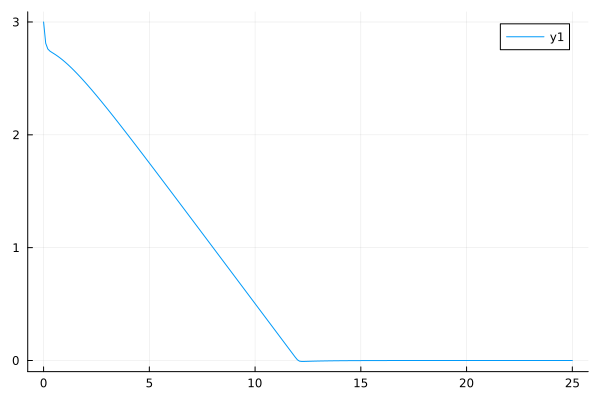

In [11]:
# x position
plot(tmpc1, Xmpc1[1,:]) 

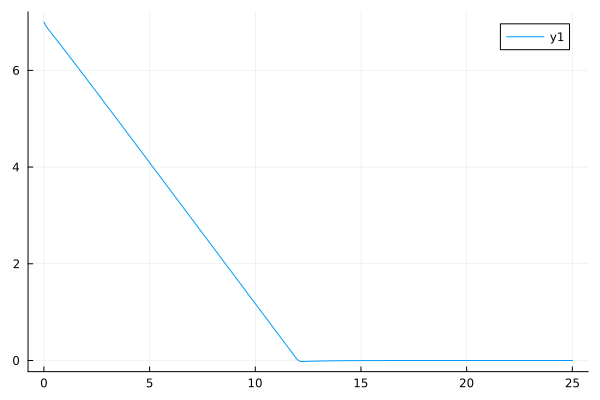

In [12]:
# y position
plot(tmpc1, Xmpc1[2,:])

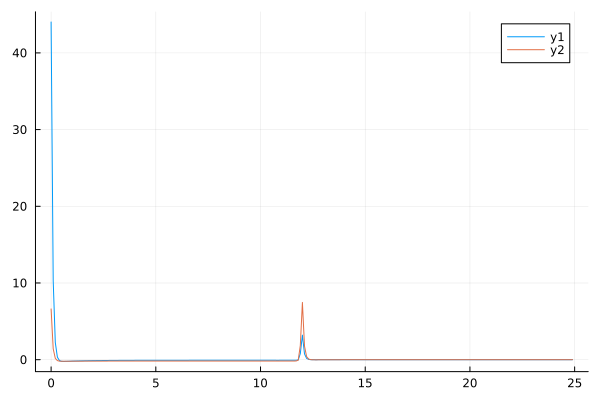

In [13]:
# x, y Force
plot(tmpc1[1:length(tmpc1)-1], Umpc1)

┌ Info: Saved animation to /home/ahmed/.julia/dev/ALMPC/examples/state_ref_MPC.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/ALMPC/examples/state_ref_MPC.gif")
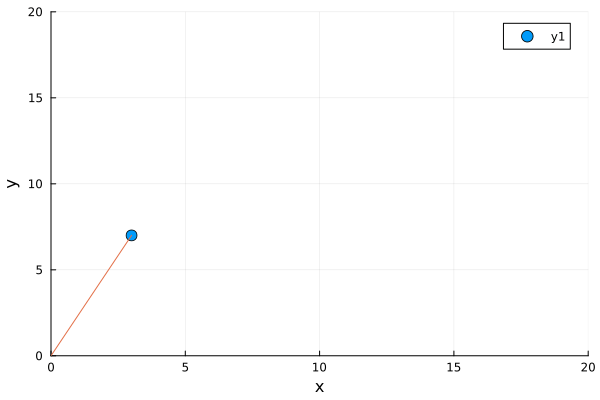

In [ ]:
anim = @animate for i in 1:length(Xmpc1[1,:])
    scatter([Xmpc1[1,i]],
            [Xmpc1[2,i]], 
            m = (:circle, 6), 
            xlims = (0, 20),
            ylims = (0, 20),
            xlabel = "x position [m]",
            ylabel = "y position [m]")
    traj2!(Xref)
end every 10;
gif(anim, "state_ref_MPC.gif")